In [3]:
NEED_TO_INSTALL_PACKAGES = False
if NEED_TO_INSTALL_PACKAGES:
    ! pip install bilby lalsimulation lalsuite
import bilby

In [4]:
from bilby.gw import conversion

#calculate the chirp mass from the component masses
chirp_mass = conversion.component_masses_to_chirp_mass(mass_1=60, mass_2=50)
print(chirp_mass)

47.642464144804954


In [5]:
POSSIBLE_KEYS = bilby.gw.prior.BBHPriorDict(aligned_spin=True).keys()
print(POSSIBLE_KEYS)

14:38 bilby INFO    : Using aligned spin prior
14:38 bilby INFO    : No prior given, using default BBH priors in /gpfs/home2/bhardwaj/venvs/tmnre_lvc/lib/python3.10/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.


dict_keys(['mass_1', 'mass_2', 'mass_ratio', 'chirp_mass', 'luminosity_distance', 'dec', 'ra', 'theta_jn', 'psi', 'phase', 'chi_1', 'chi_2'])


In [6]:
### LET US SETUP SOME INJECTION PARAMETERS
injection_parameters = dict(
    mass_1 = 60,
    mass_2 = 50,
    mass_ratio = 0.8, #m2/m1
    chirp_mass = 47.642464144804954,
    chi_1 = 0.2,
    chi_2 = 0.3,
    luminosity_distance = 400,
    theta_jn = 1.4,
    psi = 2.0,
    ra = 1.375,
    dec = -0.7,
    phase = 1.2,
    geocent_time = 100,
)

In [7]:
waveform_arguments = dict(
    waveform_approximant = 'IMRPhenomPv2',
    reference_frequency = 50,
    minimum_frequency = 20,
    sampling_frequency = 1024,
    duration = 4,
    start_time = injection_parameters['geocent_time'] - 2,
)

In [8]:
waveform_generator = bilby.gw.WaveformGenerator(
    duration = waveform_arguments['duration'],
    sampling_frequency = waveform_arguments['sampling_frequency'],
    frequency_domain_source_model = bilby.gw.source.lal_binary_black_hole,
    parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments = waveform_arguments,
)

14:38 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


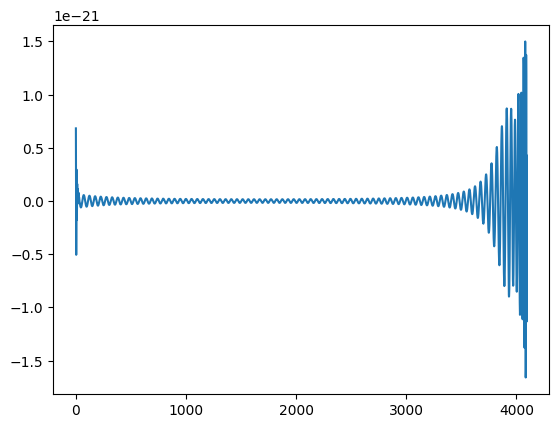

In [9]:
import matplotlib.pyplot as plt
plt.plot(waveform_generator.time_domain_strain(injection_parameters)['plus'])

In [20]:
ifos = bilby.gw.detector.InterferometerList(['H1', 'L1', 'V1'])
ifos_00 = bilby.gw.detector.InterferometerList(['H1', 'L1', 'V1'])

ifos.set_strain_data_from_power_spectral_densities(sampling_frequency=waveform_arguments['sampling_frequency'], 
                                                   duration=waveform_arguments['duration'], 
                                                   start_time=waveform_arguments['start_time'])

ifos_00.set_strain_data_from_zero_noise(sampling_frequency=waveform_arguments['sampling_frequency'],
                                        duration=waveform_arguments['duration'], 
                                        start_time=waveform_arguments['start_time'])

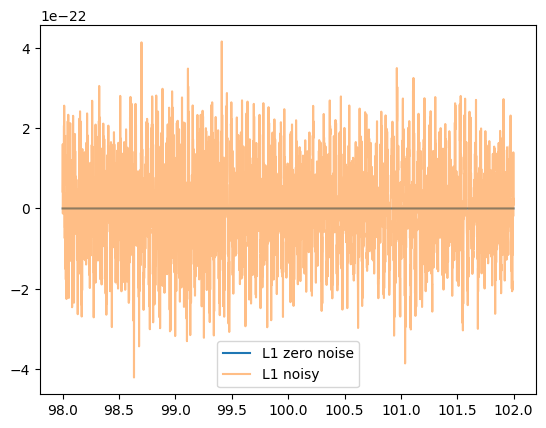

In [24]:
plt.plot(ifos_00[1].time_array, ifos_00[1].time_domain_strain, label='L1 zero noise')
plt.plot(ifos[1].time_array, ifos[1].time_domain_strain, label='L1 noisy', alpha=0.5)
plt.legend()

In [ ]:
ifos.inject_signal(
    parameters=injection_parameters,
    waveform_generator=waveform_generator,
)

ifos_00.inject_signal(
    parameters=injection_parameters,
    waveform_generator=waveform_generator,
)

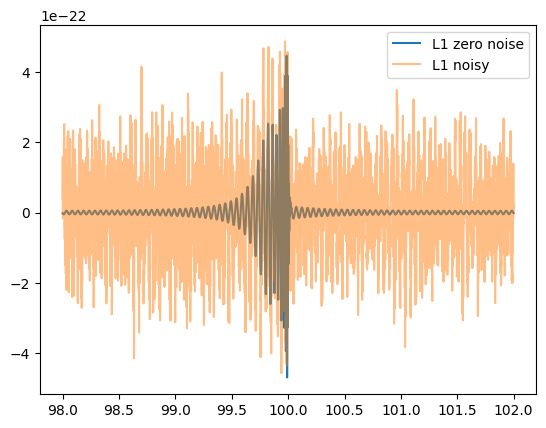

In [31]:
plt.plot(ifos_00[1].time_array, ifos_00[1].time_domain_strain, label='L1 zero noise')
plt.plot(ifos[1].time_array, ifos[1].time_domain_strain, label='L1 noisy', alpha=0.5)
plt.legend()

$p(\theta|d) = \dfrac{\mathcal{L}(d|\theta) p(\theta)}{\mathcal{Z(d)}}$

In [33]:
priors = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
priors

15:30 bilby INFO    : Using aligned spin prior
15:30 bilby INFO    : No prior given, using default BBH priors in /gpfs/home2/bhardwaj/venvs/tmnre_lvc/lib/python3.10/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.


{'mass_1': Constraint(minimum=5, maximum=100, name='mass_1', latex_label='$m_1$', unit=None),
 'mass_2': Constraint(minimum=5, maximum=100, name='mass_2', latex_label='$m_2$', unit=None),
 'mass_ratio': bilby.gw.prior.UniformInComponentsMassRatio(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None),
 'chirp_mass': bilby.gw.prior.UniformInComponentsChirpMass(minimum=25, maximum=100, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None),
 'luminosity_distance': bilby.gw.prior.UniformSourceFrame(minimum=100.0, maximum=5000.0, cosmology=FlatLambdaCDM(name="Planck15", H0=67.74 km / (Mpc s), Om0=0.3075, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.0486), name='luminosity_distance', latex_label='$d_L$', unit=Unit("Mpc"), boundary=None),
 'dec': Cosine(minimum=-1.5707963267948966, maximum=1.5707963267948966, name='dec', latex_label='$\\mathrm{DEC}$', unit=None, boundary=None),
 'ra': Uniform(minimum=0, maximum=6.283185307

In [42]:
keys_of_interest = ['chirp_mass', 'dec']
for key in priors.keys():
    if key not in keys_of_interest:
        priors[key] = injection_parameters[key]

priors['geocent_time'] = injection_parameters['geocent_time']

In [43]:
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos,
    waveform_generator=waveform_generator,
    priors=priors,
)

In [44]:
result = bilby.core.sampler.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler='dynesty',
    outdir='./outdir',
    label='legends',
    nlive=500,
)

15:49 bilby INFO    : Running for label 'legends', output will be saved to './outdir'
15:49 bilby INFO    : Using lal version 7.2.4
15:49 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.11;Id: 7a2f2aa176ad39eeaede38f6df4a41d6bf226e8f;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
15:49 bilby INFO    : Using lalsimulation version 4.0.2
15:49 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.11;Id: 7a2f2aa176ad39eeaede38f6df4a41d6bf226e8f;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
15:49 bilby INFO    : Analysis priors:
15:49 bilby INFO    : chirp_mass=bilby.gw.prior.UniformInComponentsChirpMass(minimum=25, maximum=100, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
15:49 bilby INFO    : dec=Cosine(minimum=-1.5707963267948966, maximum=1.5707963267948966, name='dec', latex_label='$\\mathrm{DEC}$', unit=None, boundary=None)
15:49 bilby INFO    : m

1it [00:00, ?it/s]

15:59 bilby INFO    : Written checkpoint file ./outdir/legends_resume.pickle
/gpfs/home2/bhardwaj/venvs/tmnre_lvc/lib/python3.10/site-packages/dynesty/plotting.py:252: RuntimeWarning: overflow encountered in exp
  np.exp(logwt), logz if logplot else np.exp(logz)
/gpfs/home2/bhardwaj/venvs/tmnre_lvc/lib/python3.10/site-packages/dynesty/plotting.py:282: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
15:59 bilby WARNING : Axis limits cannot be NaN or Inf
15:59 bilby WARNING : Failed to create dynesty run plot at checkpoint
16:04 bilby INFO    : Written checkpoint file ./outdir/legends_resume.pickle
/gpfs/home2/bhardwaj/venvs/tmnre_lvc/lib/python3.10/site-packages/dynesty/plotting.py:252: RuntimeWarning: overflow encountered in exp
  np.exp(logwt), logz if logplot else np.exp(logz)
/gpfs/home2/bhardwaj/venvs/tmnre_lvc/lib/python3.10/site-packages/dynesty/plotting.py:282: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 

16:04 bilby INFO    : Sampling time: 0:14:18.396218
16:04 bilby INFO    : Summary of results:
nsamples: 4664
ln_noise_evidence: -7425.974
ln_evidence: -5904.953 +/-  0.130
ln_bayes_factor: 1521.021 +/-  0.130



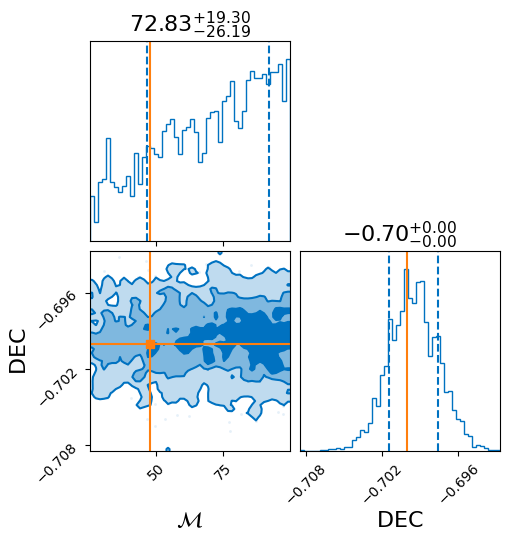

In [48]:
truths = {key:injection_parameters[key] for key in keys_of_interest}
result.plot_corner(truths=truths)